# **DISCLAIMER** 

Мне очень стыдно, что вы это увидите.

Заранее приношу извинения за причененные моральные и визуальные мучения. 

Я правда очень старалась сделать это задание, пересмотрела все лекции и семинары (некоторые по 3 раза), прочла статьи, где представляют Адама и т.д, потратила правда много времени, чтобы понять и решить. 

Простите, что это так ужасно и что моих когнитивных способностей не хватает на это ДЗ.


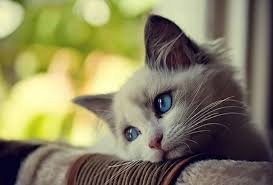 

## Домашнее задание №1. Алтунина Анастасия. ИАД-4. БЭК181

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.rand((3, 2)) - 0.25 # чтобы ReLU было чем заняться
y = torch.rand((3, 2)) - 0.25
x, y

(tensor([[ 0.1427,  0.0401],
         [ 0.1027,  0.7480],
         [-0.0761,  0.1453]]), tensor([[0.6603, 0.5094],
         [0.0563, 0.2152],
         [0.4035, 0.0128]]))

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [3]:
torch.empty((3, 3), out=(x @ y.t()))

tensor([[ 0.1146,  0.0167,  0.0581],
        [ 0.4489,  0.1668,  0.0510],
        [ 0.0238,  0.0270, -0.0289]])

In [4]:
torch.matmul(x, y.T)

tensor([[ 0.1146,  0.0167,  0.0581],
        [ 0.4489,  0.1668,  0.0510],
        [ 0.0238,  0.0270, -0.0289]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [5]:
def relu_forward(x):
    pass  
    return torch.max(torch.zeros_like(x), x)

assert torch.all(F.relu(x) == relu_forward(x))

In [6]:
F.relu(y)

tensor([[0.6603, 0.5094],
        [0.0563, 0.2152],
        [0.4035, 0.0128]])

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [7]:
def elu_forward(x):
    pass
    return torch.max(torch.zeros_like(x), x) + torch.min(torch.zeros_like(x), (torch.exp(x) - 1))

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

In [8]:
F.elu(y)

tensor([[0.6603, 0.5094],
        [0.0563, 0.2152],
        [0.4035, 0.0128]])

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [9]:
def lrelu_forward(x, alpha):
    pass
    return torch.max(torch.zeros_like(x), x) + alpha * (torch.min(torch.zeros_like(x), x))

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

In [10]:
F.leaky_relu(x)

tensor([[ 0.1427,  0.0401],
        [ 0.1027,  0.7480],
        [-0.0008,  0.1453]])

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [11]:
def mish(x):
    pass
    return x *(torch.tanh(torch.log(1+torch.exp(x))))

In [12]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

In [13]:
mish(x)

tensor([[ 0.0920,  0.0246],
        [ 0.0650,  0.6081],
        [-0.0438,  0.0939]])

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [14]:
def swish(x):
    pass
    return (x * (1/(1+torch.exp(-x))))

In [15]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

In [16]:
swish(x)

tensor([[ 0.0764,  0.0204],
        [ 0.0540,  0.5077],
        [-0.0366,  0.0779]])

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [17]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [18]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            d_param = param.grad
    
            buffer = self._get_adam_buffer(param)
            t = buffer['step']
            mom2 = buffer['momentum2']
            buffer['momentum'].mul_(beta_1)
            buffer['momentum'].add_(d_param, alpha=(1-beta_1))

            buffer['momentum2'].mul_(beta_2)
            buffer['momentum2'].add_(d_param ** 2, alpha=(1-beta_2))
        
            h_mom2 = buffer['momentum2'] / (1 - beta_2 ** t)
            h_mom = buffer['momentum'] / (1 - beta_1 ** t)
            buffer['step'] += 1
            param.add_(h_mom / torch.sqrt(h_mom2 + eps), alpha=-lr)

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_buffer']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer' not in param_state:
            param_state['adam_buffer'] = {"step": 1, "momentum": torch.zeros_like(param), "momentum2": torch.zeros_like(param)}

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

```
n_in = 784
n_out = 10
```
Потому что у нас 10 классов (цифр, изображенных на картинках) и 784 входных параметров - пикселей на каждой картинке (картинки размером $28$ x $28$).


In [19]:
n_in = 784
n_out = 10
weights = torch.FloatTensor(10, 784).uniform_(-math.sqrt(6)/math.sqrt(n_in+n_out), math.sqrt(6)/math.sqrt(n_in+n_out))
intercept = torch.zeros(10)

In [20]:
optimizer = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [21]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = DataLoader(fashion_mnist_train, 
                              batch_size=100, shuffle=True, num_workers=2)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=100, shuffle=True, num_workers=2)

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [8]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    x = batch[0].view(784, 10)
    y = batch[1]
    size = x.shape[0]
    for i in range(len(batch)): 
        sigma = 1 / (1 + torch.exp((torch.matmul(x, weights.T) + bias)))
        loss = -1/size * torch.sum(y * torch.log(sigma)) + (1 - y) * torch.log(1-sigma)
        dW = 1/size * torch.matmul(x.T, (sigma - y))
        db = 1/size * torch.sum(sigma - y)
        weights -= learning_rate * dW
        bias -= learning_rate * db 
    return (weight, bias)

In [ ]:
learning_rate = 0.02 
loss = nn.CrossEntropyLoss()
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)

In [23]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets

batch_size = 100
n_iters = 3000
epochs = 100
input_dim = 784
output_dim = 10
lr_rate = 0.001
iter = 0
iters = list()
losses = list()
accuracies = list()

train_dataset = fashion_mnist_train
test_dataset = fashion_mnist_eval


train_loader = train_dataloader
test_loader = eval_dataloader

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters()) #Adam([weights, intercept]) 


for epoch in range(1, 30):
  for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                images = images.float()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= float(labels.size(0))
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum().float()
            accuracy = 100 * (correct / total)
            iters.append(iter)
            losses.append(loss.item())
            accuracies.append(accuracy)
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.43645909428596497. Accuracy: 80.58999633789062.
Iteration: 1000. Loss: 0.434006929397583. Accuracy: 82.27000427246094.
Iteration: 1500. Loss: 0.410329669713974. Accuracy: 83.26000213623047.
Iteration: 2000. Loss: 0.34544268250465393. Accuracy: 83.61000061035156.
Iteration: 2500. Loss: 0.5305755734443665. Accuracy: 83.52000427246094.
Iteration: 3000. Loss: 0.430210679769516. Accuracy: 83.94000244140625.
Iteration: 3500. Loss: 0.5236878991127014. Accuracy: 83.7300033569336.
Iteration: 4000. Loss: 0.4344162046909332. Accuracy: 83.95000457763672.
Iteration: 4500. Loss: 0.3154470920562744. Accuracy: 84.11000061035156.
Iteration: 5000. Loss: 0.5139772891998291. Accuracy: 84.30000305175781.
Iteration: 5500. Loss: 0.4140048623085022. Accuracy: 84.47000122070312.
Iteration: 6000. Loss: 0.3847584128379822. Accuracy: 84.41000366210938.
Iteration: 6500. Loss: 0.35002583265304565. Accuracy: 84.19999694824219.
Iteration: 7000. Loss: 0.3216848373413086. Accuracy: 84.5599975585

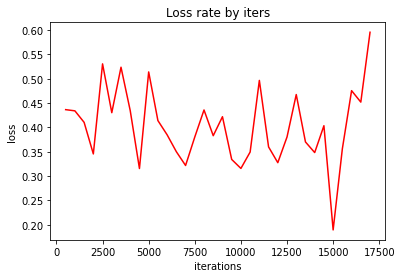

In [24]:
plt.plot(iters, losses, 
    label='loss_iter', c='red'
)
plt.title('Loss rate by iters')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

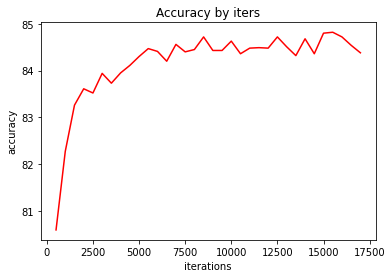

In [25]:
plt.plot(iters, accuracies, 
    label='loss_iter', c='red'
)
plt.title('Accuracy by iters')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

## Ответ:

$\bullet$ Потому что он берет при обновлении моментума-2 крадрат градиента и прибавляет его (диагональную матрицу с кваратами элементов градиента, если быть точной) к старому значению, умноженному на коэффициент, то есть происходит движение в направлении, которое задается этим моентумом-2. Если взять матожадание от самого веса на шаге t (при этом нужно перенести туда еще и старое значение моментума-2), то получим, что оно равно матожиданию  квадрата градиента, умноженному на выражение с параметрами бета-2, что и значит, то получается несмещенная оценка на квадрат градиента.

$\bullet$ Модель начала переобучаться, когда accuracy перестала расти, а loss при этом сильно разбрасывает. Примерно на 15-16 эпохе.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
batch_size = 100
n_iters = 3000
epochs = 100
input_dim = 784
output_dim = 10
lr_rate = 0.001
iter = 0

In [ ]:
def train_model(model, dataloader, optimizer):
    model = model.train()
    dataloader

In [ ]:
second_model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax()
)

In [ ]:
second_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv2d(32, 64, kernel_size=(3, 3), stride

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(16 * 14 * 14, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()

        
    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

model_b = Model()

In [ ]:
def train_my_model(model, iterations, criterion, optimizer):
  iter = 0
  iters = list()
  losses = list()
  accuracies = list()

  for epoch in range(1, iterations):
    for i, (images, labels) in enumerate(train_dataloader):
        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            correct = 0
            total = 0
            for images, labels in eval_dataloader:
                images = Variable(images)
                images = images.float()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= float(labels.size(0))
                correct+= (predicted == labels).sum().float()
            accuracy = 100 * (correct / total)
            iters.append(iter)
            losses.append(loss.item())
            accuracies.append(accuracy)
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

  plt.plot(iters, losses, 
    label='loss_iter', c='red')
  plt.title('Loss rate by iters')
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.show()

  plt.plot(iters, accuracies, 
    label='loss_iter', c='red')
  plt.title('Accuracy by iters')
  plt.xlabel('iterations')
  plt.ylabel('accuracy')
  plt.show()

In [ ]:
model1 = LogisticRegression(input_dim, output_dim)

Iteration: 500. Loss: 0.6902686357498169. Accuracy: 75.76000213623047.
Iteration: 1000. Loss: 0.5744527578353882. Accuracy: 78.64999389648438.
Iteration: 1500. Loss: 0.5588098168373108. Accuracy: 79.90999603271484.
Iteration: 2000. Loss: 0.6599846482276917. Accuracy: 80.98999786376953.
Iteration: 2500. Loss: 0.5456490516662598. Accuracy: 81.22000122070312.
Iteration: 3000. Loss: 0.5085885524749756. Accuracy: 81.56999969482422.
Iteration: 3500. Loss: 0.43926113843917847. Accuracy: 82.02000427246094.
Iteration: 4000. Loss: 0.573198676109314. Accuracy: 82.1500015258789.
Iteration: 4500. Loss: 0.4262116253376007. Accuracy: 82.70000457763672.
Iteration: 5000. Loss: 0.44663524627685547. Accuracy: 82.62000274658203.
Iteration: 5500. Loss: 0.5981827974319458. Accuracy: 82.7300033569336.
Iteration: 6000. Loss: 0.5114998817443848. Accuracy: 82.55000305175781.
Iteration: 6500. Loss: 0.4435240626335144. Accuracy: 82.94000244140625.
Iteration: 7000. Loss: 0.43843743205070496. Accuracy: 82.840003967

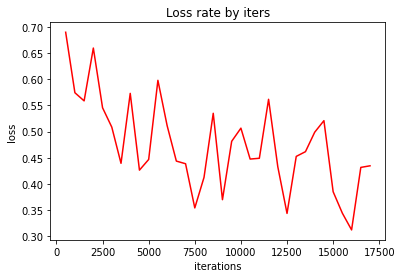

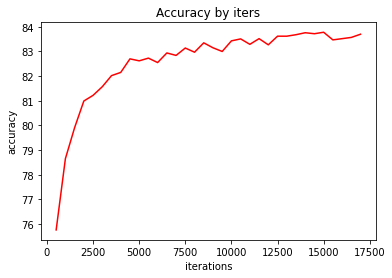

In [ ]:
train_my_model(model1, 30, torch.nn.CrossEntropyLoss(), torch.optim.SGD(model1.parameters(), lr=0.02))

Iteration: 500. Loss: 0.5408148169517517. Accuracy: 83.49000549316406.
Iteration: 1000. Loss: 0.4422314465045929. Accuracy: 84.02999877929688.
Iteration: 1500. Loss: 0.4346010684967041. Accuracy: 84.01000213623047.
Iteration: 2000. Loss: 0.3592582046985626. Accuracy: 83.91000366210938.
Iteration: 2500. Loss: 0.4454893171787262. Accuracy: 84.13999938964844.
Iteration: 3000. Loss: 0.435546875. Accuracy: 84.33000183105469.
Iteration: 3500. Loss: 0.27704304456710815. Accuracy: 82.8499984741211.
Iteration: 4000. Loss: 0.46649956703186035. Accuracy: 82.11000061035156.
Iteration: 4500. Loss: 0.5294294357299805. Accuracy: 83.51000213623047.
Iteration: 5000. Loss: 0.3476013243198395. Accuracy: 84.38999938964844.
Iteration: 5500. Loss: 0.3921850919723511. Accuracy: 83.9800033569336.
Iteration: 6000. Loss: 0.5244991183280945. Accuracy: 84.41999816894531.
Iteration: 6500. Loss: 0.542685866355896. Accuracy: 83.9000015258789.
Iteration: 7000. Loss: 0.26478779315948486. Accuracy: 84.51000213623047.
I

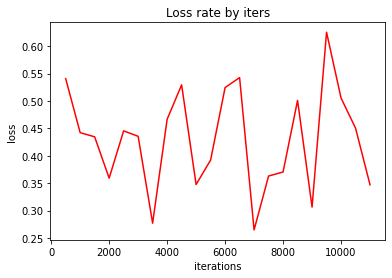

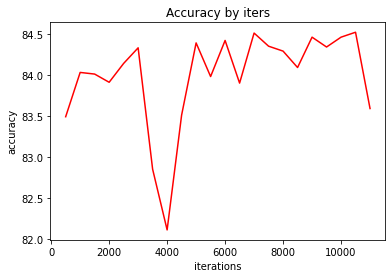

In [ ]:
train_my_model(model1, 20, torch.nn.CrossEntropyLoss(), torch.optim.RMSprop(model1.parameters(), lr=0.002))

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 2.297421932220459. Accuracy: 10.520000457763672.
Iteration: 1000. Loss: 2.2501444816589355. Accuracy: 27.360000610351562.
Iteration: 1500. Loss: 1.9506285190582275. Accuracy: 66.43000030517578.
Iteration: 2000. Loss: 1.7077670097351074. Accuracy: 74.47999572753906.
Iteration: 2500. Loss: 1.6988929510116577. Accuracy: 76.06999969482422.
Iteration: 3000. Loss: 1.7206975221633911. Accuracy: 77.1500015258789.
Iteration: 3500. Loss: 1.6508713960647583. Accuracy: 77.62000274658203.
Iteration: 4000. Loss: 1.7483160495758057. Accuracy: 77.20000457763672.
Iteration: 4500. Loss: 1.6839522123336792. Accuracy: 76.20000457763672.
Iteration: 5000. Loss: 1.6629186868667603. Accuracy: 78.47000122070312.
Iteration: 5500. Loss: 1.6315078735351562. Accuracy: 78.37999725341797.
Iteration: 6000. Loss: 1.6385524272918701. Accuracy: 78.79999542236328.
Iteration: 6500. Loss: 1.6713224649429321. Accuracy: 77.34000396728516.
Iteration: 7000. Loss: 1.6592016220092773. Accuracy: 78.5.
Iterat

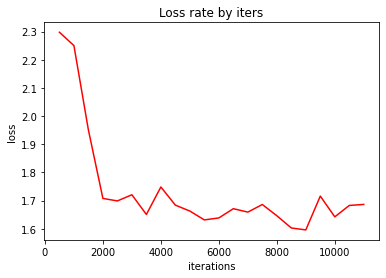

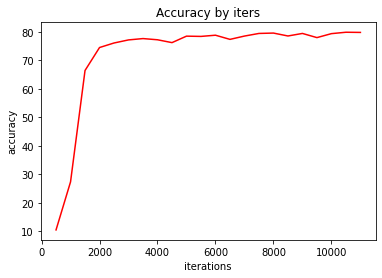

In [ ]:
train_my_model(model_b, 20, criterion, torch.optim.SGD(model_b.parameters(), lr=0.01))